# 0.0 IMPORTS

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from tabulate import tabulate
from IPython.display import Image

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.rcParams['font.size'] = 30
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [4]:
df_raw = pd.read_csv( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/data/raw/train.csv' )

In [5]:
pwd

'/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/notebooks'

# 1.0 STEP 01 - DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

## 1.1 Columns Description

In [7]:
tab_meanings = [['Column', 'Meaning'],
        ['id', 'unique customer identifier.'],
        ['gender', 'client gender: Male / Female.'],
        ['age', 'customer age.'],
        ['region_code', 'customer region code.'],
        ['policy_sales_channel', 'Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..'],
        ['driving_license', '0 = customer does not have DL, 1 = already have DL'],
        ['vehicle_age', 'vehicle age: < 1 Year, 1-2 Year, > 2 Years'],
        ['vehicle_damage', 'No = customer has never had their vehicle damaged in the past, Yes = has had it.'],
        ['vehicle_prev_insured', '0 = customer does not have vehicle insurance, 1= already has vehicle insurance.'],
        ['health_annual_premium', 'annual amount paid by the customer to the company for health insurance. Currency: Rs(Pakistani rupee, R$1.00 = ± Rs0.03).'],
        ['days_associated', 'number of days since the customer joined the company by purchasing health insurance. The policy is annual.'],
        ['response', '0 = customer is not interested, 1 = customer is interested.']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='rst'))

=====================  =========================================================================================================================
Column                 Meaning
=====================  =========================================================================================================================
id                     unique customer identifier.
gender                 client gender: Male / Female.
age                    customer age.
region_code            customer region code.
policy_sales_channel   Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..
driving_license        0 = customer does not have DL, 1 = already have DL
vehicle_age            vehicle age: < 1 Year, 1-2 Year, > 2 Years
vehicle_damage         No = customer has never had their vehicle damaged in the past, Yes = has had it.
vehicle_prev_insured   0 = customer does not have vehicle insurance, 1= already has vehicle insurance.
health_annual_p

### 1.1.1 Columns Exemple

In [8]:
df1.head()

,id,previously_insured,annual_premium,vintage,response,id.1,gender,age,region_code,policy_sales_channel,id.2,driving_license,vehicle_age,vehicle_damage
0,7,0,23367.0,249,0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes
1,13,1,31409.0,221,0,13,Female,41,15.0,14.0,13,1,1-2 Year,No
2,18,1,46622.0,299,0,18,Female,25,35.0,152.0,18,1,< 1 Year,No
3,31,0,2630.0,136,0,31,Female,26,8.0,160.0,31,1,< 1 Year,No
4,39,0,42297.0,264,0,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes


## 1.2 Data Dimensions

In [9]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Cols: {df1.shape[1]}' )

Number of Rows: 381109
Number of Cols: 14


## 1.3 Data Types

In [10]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
id.1                      int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
id.2                      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 1.4 Check NA's

In [11]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
id.1                    0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
id.2                    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.5 Fill NA's

In [12]:
# Not Necessary

## 1.6 Change Types

In [13]:
df1['region_code'] = df1['region_code'].astype( int )

In [14]:
# Check Change
df1['region_code'].dtypes

dtype('int64')

## 1.7 Drop Columns

In [15]:
df1 = df1.drop( columns=['id.1', 'id.2'] )

## 1.8 Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes( include=['int64', np.float64] )
cat_attributes = df1.select_dtypes( exclude=['int64', np.float64] )

### 1.8.1 Numerical Attributes

In [17]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - Std, min, max, range, skewness, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
2,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
3,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
4,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
5,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
6,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
7,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
8,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302


### 1.8.2 Categorical Attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

<AxesSubplot:xlabel='vehicle_age', ylabel='id'>

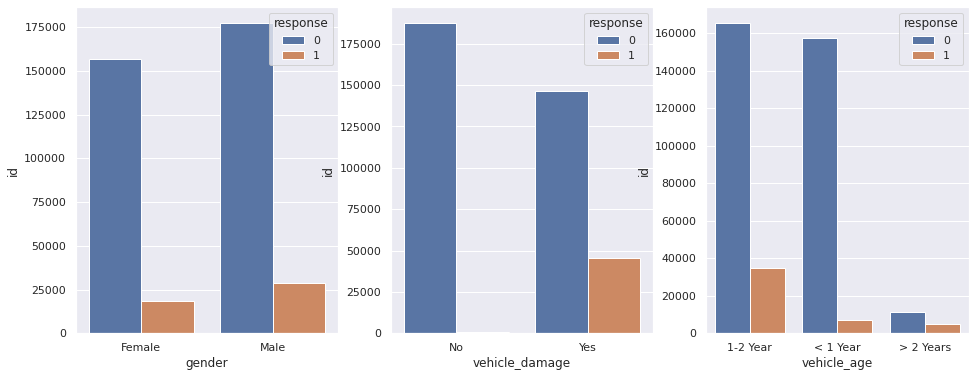

In [20]:
aux = df1.copy()

plt.figure( figsize=(16, 6) )

# Graph 1 - Gender
plt.subplot( 131 )
aux1 = aux[['gender', 'response', 'id']].groupby( ['gender', 'response'] ).count().reset_index()
sns.barplot( x='gender', y='id', hue='response', data=aux1 )


# Graph 2 - Vehicle Damage
plt.subplot( 132 )
aux1 = aux[['vehicle_damage', 'response', 'id']].groupby( ['vehicle_damage', 'response'] ).count().reset_index()
sns.barplot( x='vehicle_damage', y='id', hue='response', data=aux1 )


# Graph 3 - Vehicle Age
plt.subplot( 133 )
aux1 = aux[['vehicle_age', 'response', 'id']].groupby( ['vehicle_age', 'response'] ).count().reset_index()
sns.barplot( x='vehicle_age', y='id', hue='response', data=aux1 )

# 2.0 STEP 02 - FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1 Hypothesis Mindmap

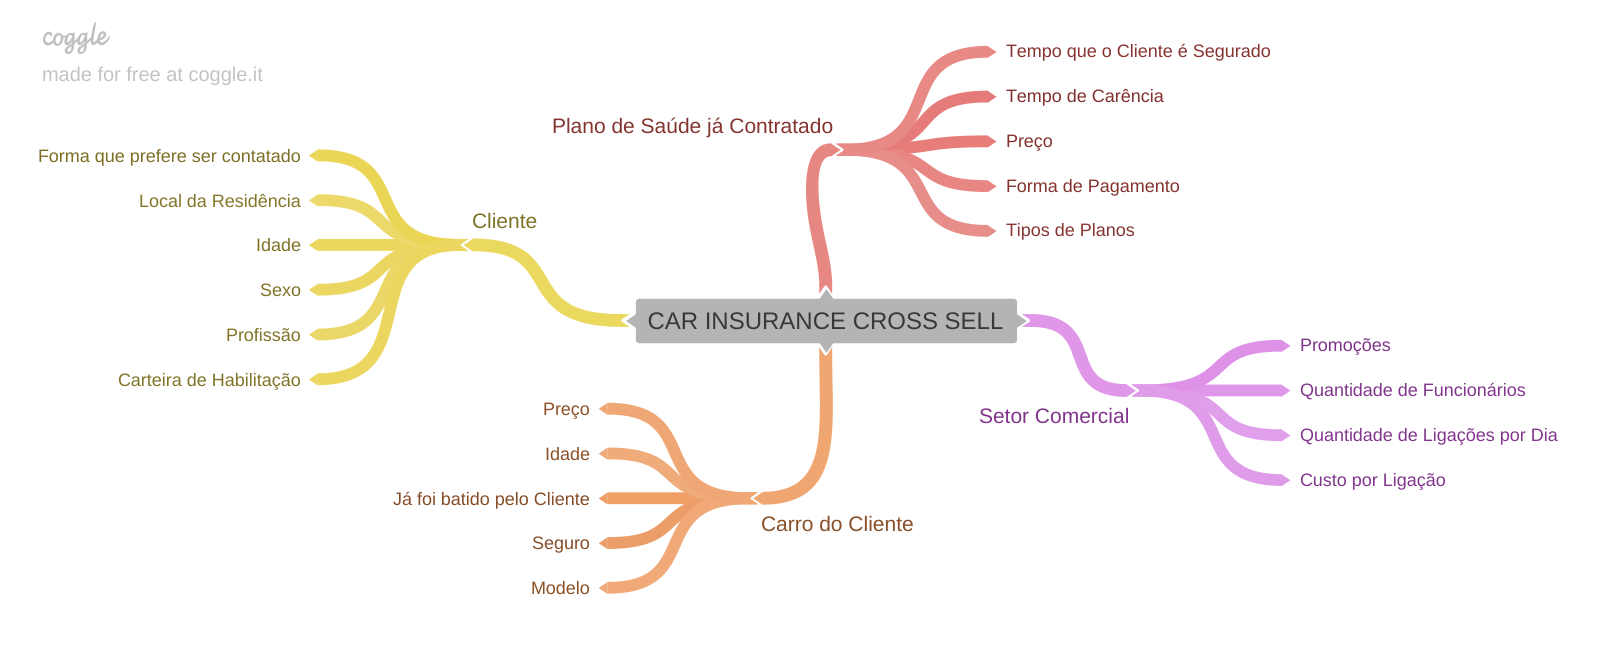

In [59]:
Image( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/img/mindmap_hypothesis_cross_sell.png' )

## 2.2 Hypothesis Creating

### 2.2.1 Client Hypotheses

**1.** Clientes com maior idade compram mais seguro de carro.

**2.** Clientes do sexo feminino compra mais seguro de carro.

### 2.2.2 Car Hypotheses

**1.** Carros mais velhos possuem menos seguros de carro.

**2.** Carros que nunca foram batidos possuem menos seguro de carro.

### 2.2.3 Health Insurance Hypotheses

**1.** Clientes com planos de saúde mais caros, comprar mais seguro de carro.

**2.** Clientes que são segurados a mais tempo pelo plano de saúde, compram mais o seguro de carro.

### 2.2.4 Hypotheses Final List

**1.** Clientes com maior idade compram mais seguro de carro.

**2.** Clientes do sexo feminino compra mais seguro de carro.

**3.** Carros mais velhos possuem menos seguros de carro.

**4.** Carros que nunca foram batidos possuem menos seguro de carro.

**5.** Clientes com planos de saúde mais caros, comprar mais seguro de carro.

**6.** Clientes que são segurados a mais tempo pelo plano de saúde, compram mais o seguro de carro.

## 2.3 Feature Engineering

In [23]:
# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'below_1_year' if x == '< 1 Year' else 
                                                         'between_1_2_year' if x == '1-2 Year' else 
                                                         'over_2_years' )

# 3.0 STEP 03 - DATA FILTERING

In [24]:
df3 = df2.copy()

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [25]:
df4 = df3.copy()

## 4.1 Univariate Analysis

In [26]:
df4.columns

Index(['id', 'previously_insured', 'annual_premium', 'vintage', 'response',
       'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage'],
      dtype='object')

### 4.1.1 Response Variable

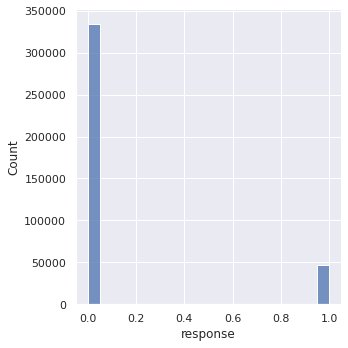

In [66]:
sns.displot( df4['response'] )

### 4.1.2 Age

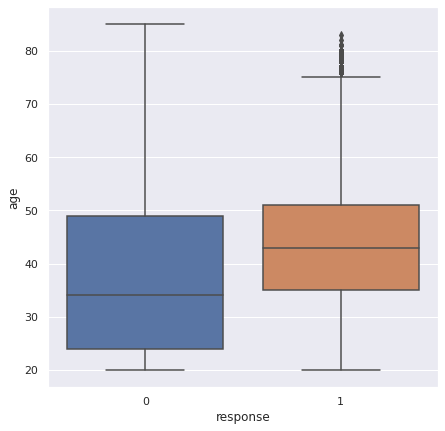

In [27]:
# age
sns.set(rc={'figure.figsize':(7, 7)})
sns.boxplot( x='response', y='age', data=df4 );

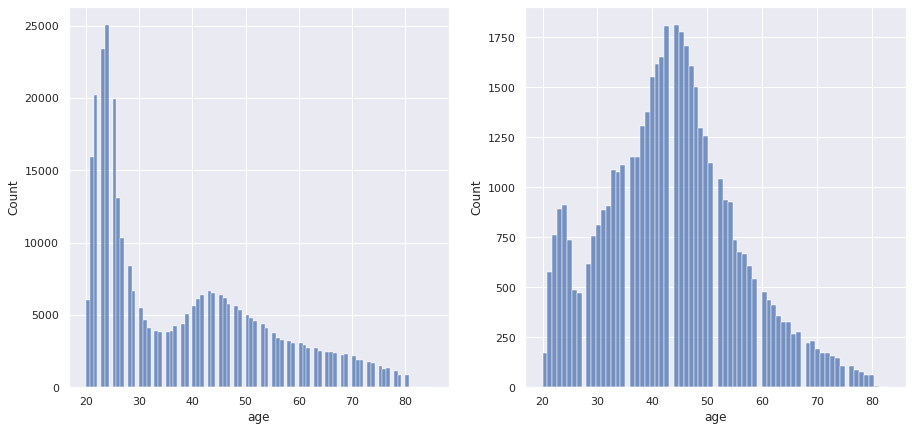

In [28]:
# Plot size
sns.set(rc={'figure.figsize':(15, 7)})

# Graph 1 - 'No'
plt.subplot( 121 )
aux1 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux1 );

# Graph 2 - 'Yes'
plt.subplot( 122 )
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux1 );

### 4.1.3 Annual Premium

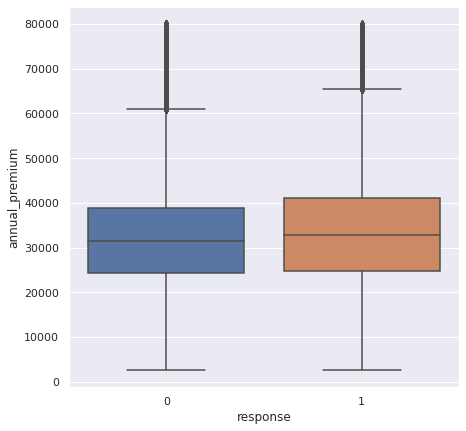

In [29]:
# annual_premium
sns.set(rc={'figure.figsize':(7, 7)})
aux1 = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux1 );

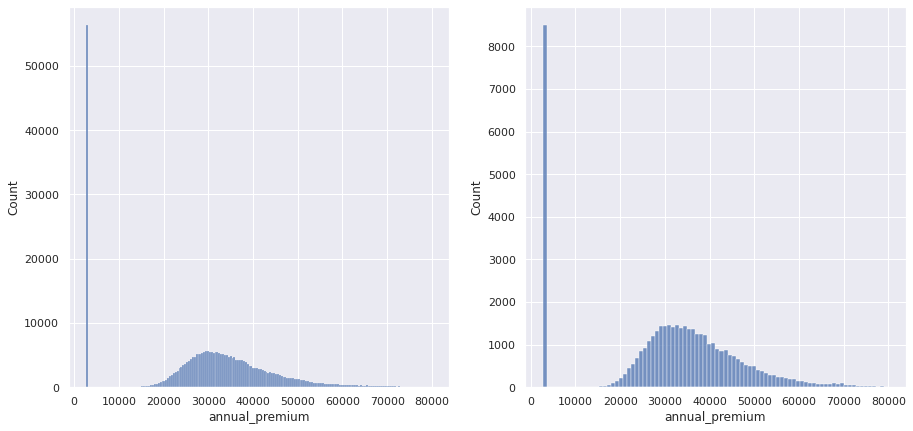

In [30]:
# Plot size
sns.set(rc={'figure.figsize':(15, 7)})

# Graph 1 - 'No'
plt.subplot( 121 )
aux2 = aux1.loc[aux1['response'] == 0, 'annual_premium']
sns.histplot( aux2 );

# Graph 2 - 'Yes'
plt.subplot( 122 )
aux3 = aux1.loc[aux1['response'] == 1, 'annual_premium']
sns.histplot( aux3 );

### 4.1.4 Driving License

In [31]:
# driving_license
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux.head()

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,driving_license_perc
0,7,0,23367.0,249,0,Male,23,11,152.0,1,< 1 Year,Yes,0.000003
1,13,1,31409.0,221,0,Female,41,15,14.0,1,1-2 Year,No,0.000003
2,18,1,46622.0,299,0,Female,25,35,152.0,1,< 1 Year,No,0.000003
3,31,0,2630.0,136,0,Female,26,8,160.0,1,< 1 Year,No,0.000003
4,39,0,42297.0,264,0,Male,45,8,124.0,1,1-2 Year,Yes,0.000003


<AxesSubplot:xlabel='response', ylabel='driving_license'>

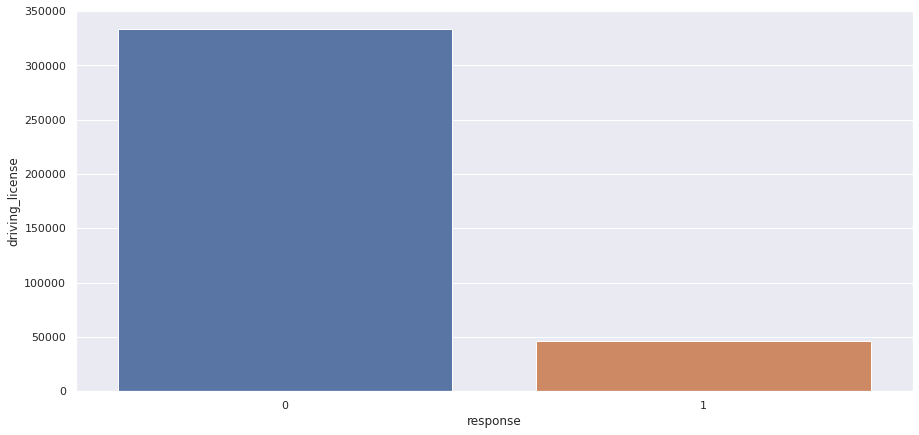

In [32]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux )

### 4.1.5 Region Code

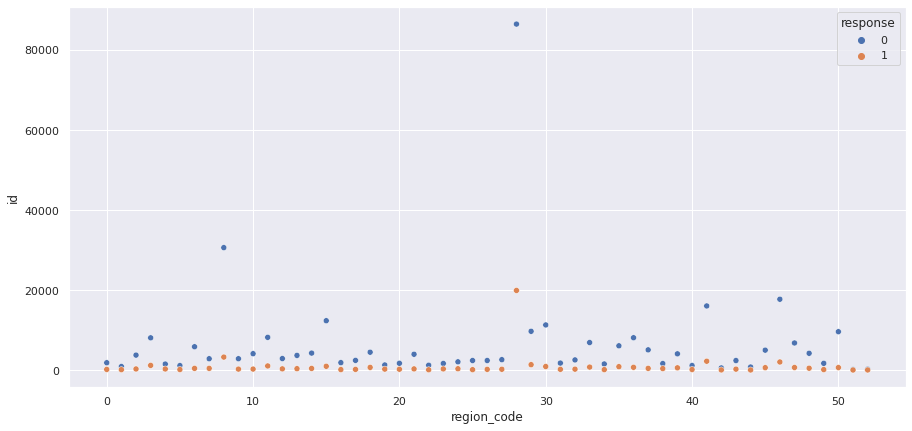

In [33]:
# region_code
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 );

### 4.1.6 Previously Insured

In [34]:
# previously insured
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 4.1.7 Vehicle Age

In [35]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


### 4.1.8 Policy Sales Channel

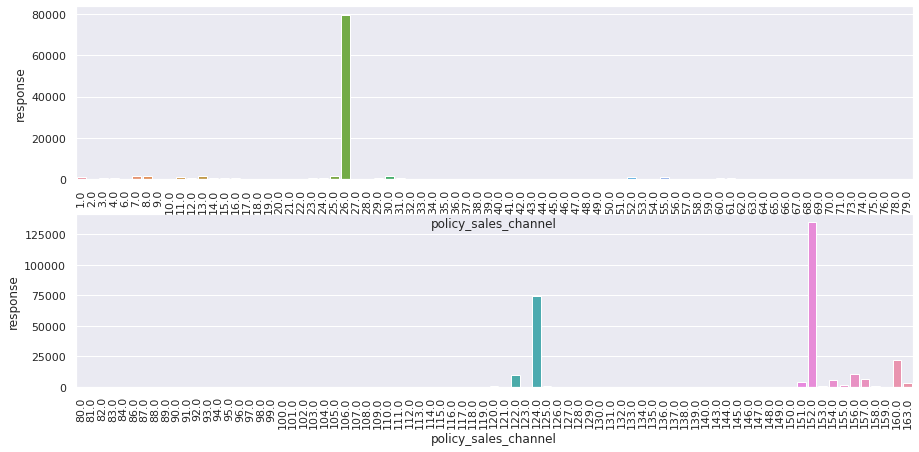

In [36]:
plt.subplot( 212 )
aux1 = df4[df4['policy_sales_channel'] >= 80.0].groupby( 'policy_sales_channel' )['response'].count().reset_index()
sns.barplot( x='policy_sales_channel', y='response', data=aux1 )
plt.xticks(rotation=90);

plt.subplot( 211 )
aux2 = df4[df4['policy_sales_channel'] < 80.0].groupby( 'policy_sales_channel' )['response'].count().reset_index()
sns.barplot( x='policy_sales_channel', y='response', data=aux2 )
plt.xticks(rotation=90);

In [37]:
# Select Columns and Policy Sales Channel <= 80
aux1 = df4[df4['policy_sales_channel'] <= 80][['response', 'policy_sales_channel']]
aux1['policy_sales_channel'] = aux1['policy_sales_channel'].astype( 'int' )



# Response Percentage by Policy Sales Channel
cross_tab_prop1 = pd.crosstab( index=aux1['policy_sales_channel'],
                              columns=aux1['response'],
                              normalize="index" )

# =========================================================================================================

# Select Columns and Policy Sales Channel > 80
aux2 = df4[df4['policy_sales_channel'] > 80][['response', 'policy_sales_channel']]
aux2['policy_sales_channel'] = aux2['policy_sales_channel'].astype( 'int' )

# Response Percentage by Policy Sales Channel
cross_tab_prop2 = pd.crosstab( index=aux2['policy_sales_channel'],
                              columns=aux2['response'],
                              normalize="index" )

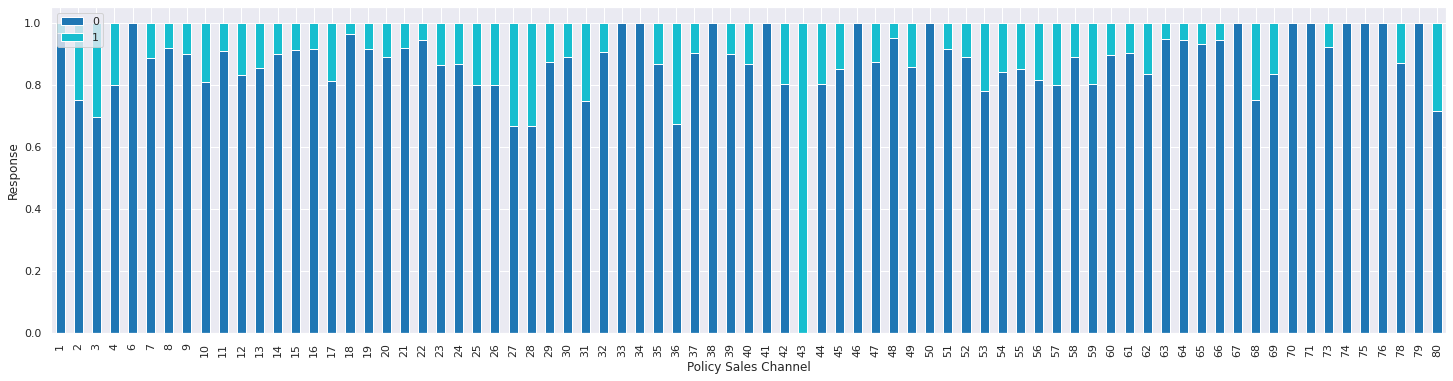

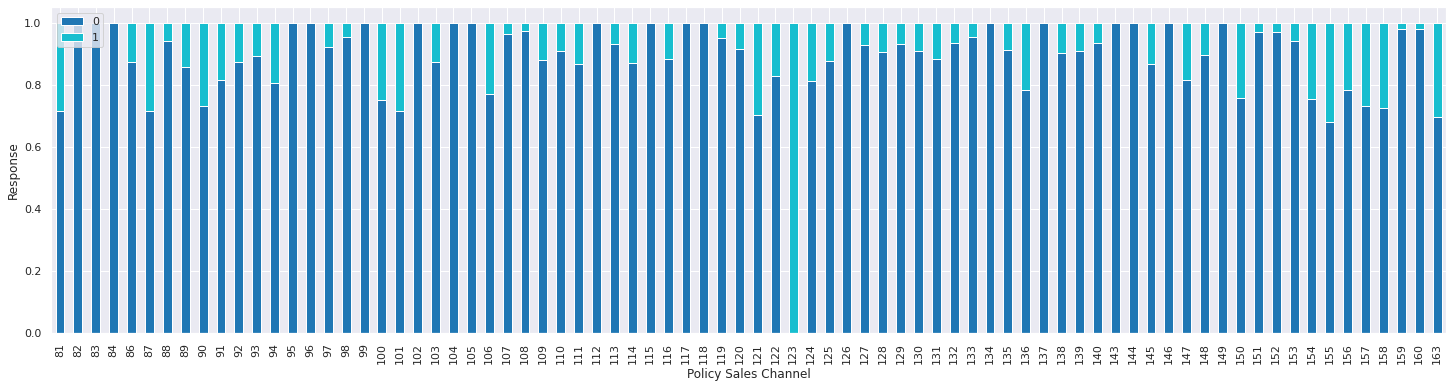

In [87]:
# Graph 1 - Policy Sales Channel <= 80
# plt.subplot( 211 )
cross_tab_prop1.plot( kind='bar',
                     stacked=True,
                     colormap='tab10',
                     figsize=(25, 6))

plt.legend( loc='upper left', ncol=1 )
plt.xlabel( 'Policy Sales Channel' )
plt.ylabel( 'Response' )
plt.xticks( rotation=90 )
plt.show()

# Graph 2 - Policy Sales Channel > 80
# plt.subplot( 212 )
cross_tab_prop2.plot( kind='bar',
                     stacked=True,
                     colormap='tab10',
                     figsize=(25, 6))

plt.legend( loc='upper left', ncol=1 )
plt.xlabel( 'Policy Sales Channel' )
plt.ylabel( 'Response' )
plt.xticks( rotation=90 )
plt.show()

### 4.1.9 Vintage

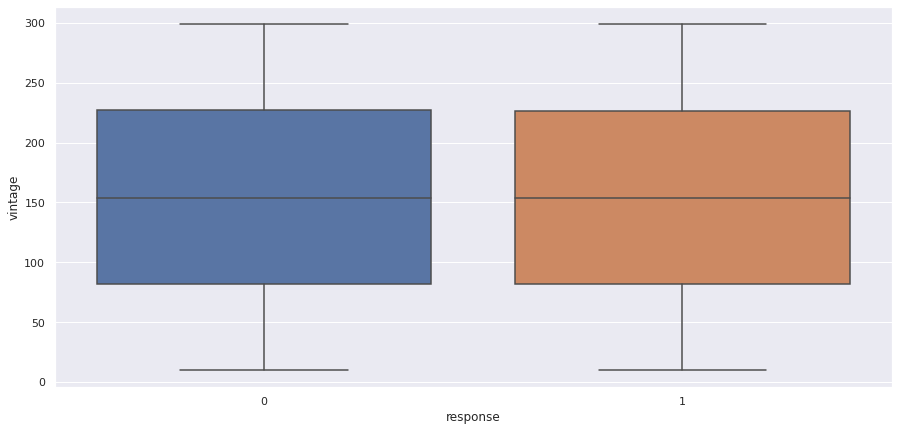

In [39]:
# vintage
sns.boxplot( x='response', y='vintage', data=df4 );

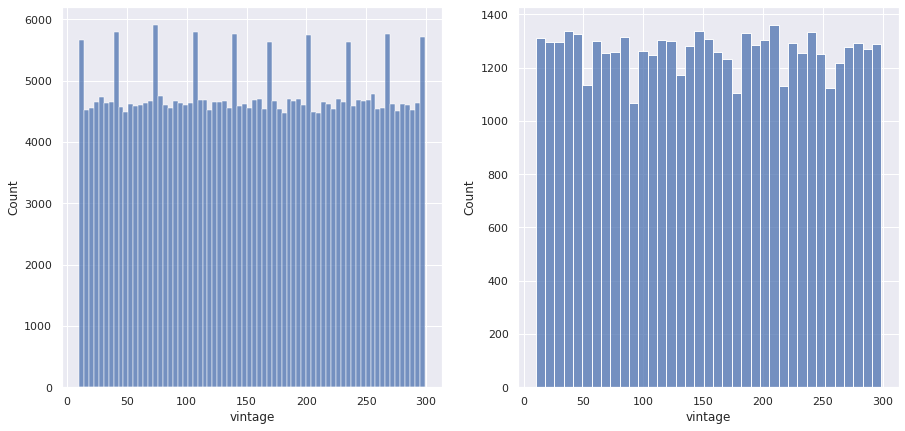

In [40]:
# Graph 1 - Dist of Response = No
plt.subplot( 121 )
aux1 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux1 );

# Graph 1 - Dist of Response = Yes
plt.subplot( 122 )
aux2 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux2 );

## 4.2 Bivariate Analysis

### **1.** Clientes com maior idade compram mais seguros de carro.

**VERDADEIRA** Clientes com maior idade compram mais seguro de carro até a idade de 44 anos.

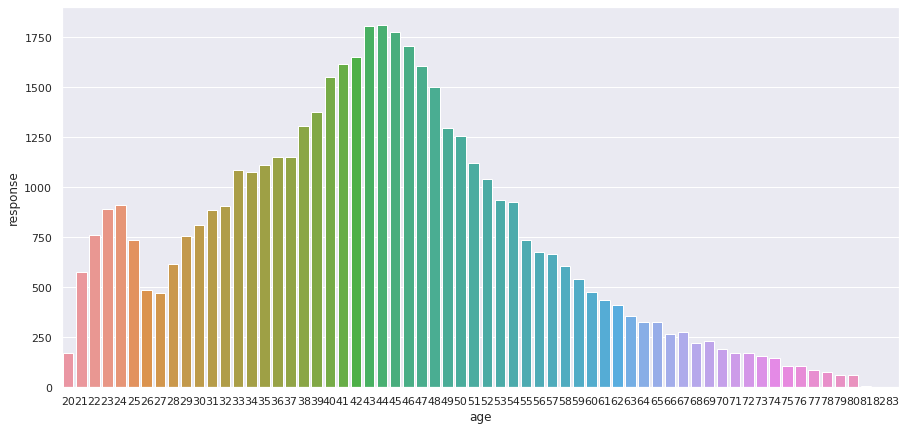

In [74]:
aux1 = df4[df4['response'] == 1]
aux2 = aux1[['response', 'age']].groupby( 'age' ).count().reset_index()
sns.barplot( x='age', y='response', data=aux2 );

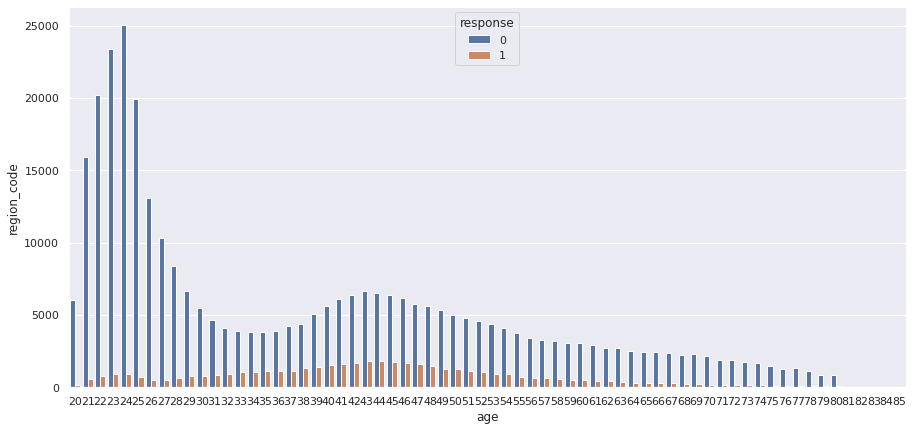

In [84]:
aux3 = df4[['response', 'age', 'region_code']].groupby( ['response', 'age'] ).count().reset_index()
sns.barplot( x='age', y='region_code', hue='response', data=aux3 );

### **2.** Clientes do gênero feminino compram mais seguros de carro.

**FALSA** Clientes do gênero feminino compram menos seguros do que do gênero masculino.

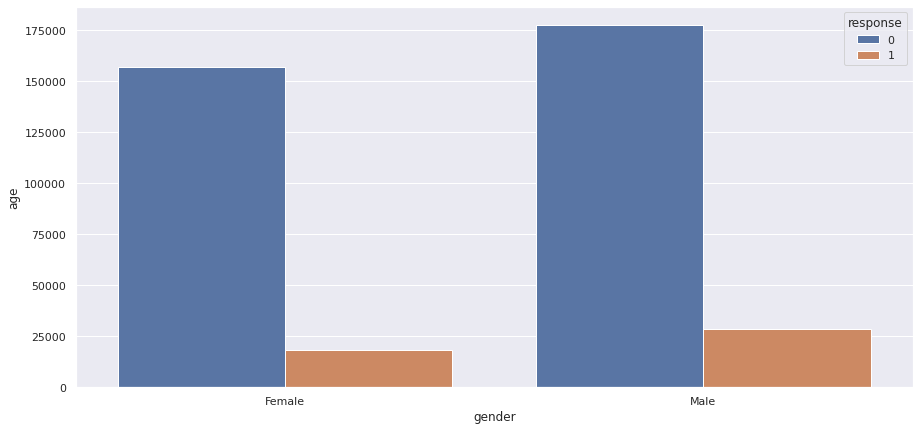

In [98]:
aux00 = df4[['response', 'gender', 'age']].groupby( ['gender', 'response'] ).count().reset_index()
sns.barplot( x='gender', y='age', hue='response', data=aux00 );

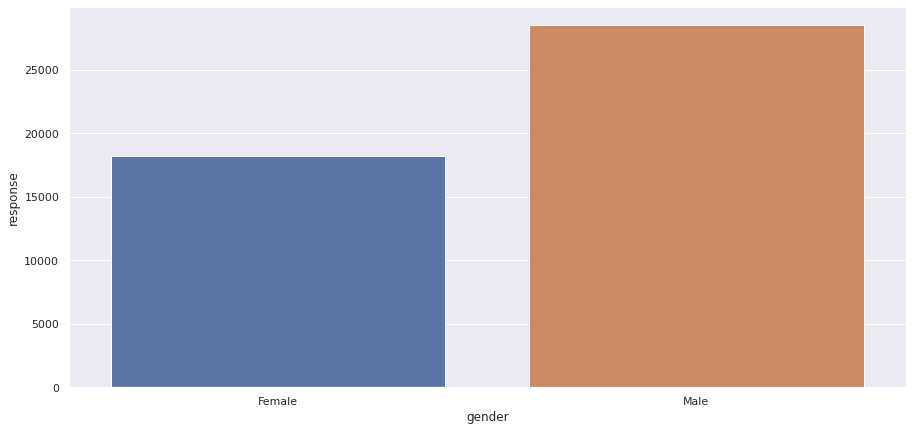

In [86]:
aux1 = df4[df4['response'] == 1]
aux2 = aux1[['response', 'gender']].groupby( 'gender' ).count().reset_index()
sns.barplot( x='gender', y='response', data=aux2 );

### **3.** Carros mais velhos possuem menos seguros de carro.

**VERDADEIRA** Apesar de ter uma menor quantidade de dados referentes aos carros mais velhos, em valores brutos eles realmente são os que possuem a menor quantidade de seguros. E ao contrário do que se imaginava com a hipótese de que os carros mais novos seriam os com maior quantidade de seguros, na verdade os carros com idade entre 1 e 2 foram os que tiverem a maior quantidade de seguros.

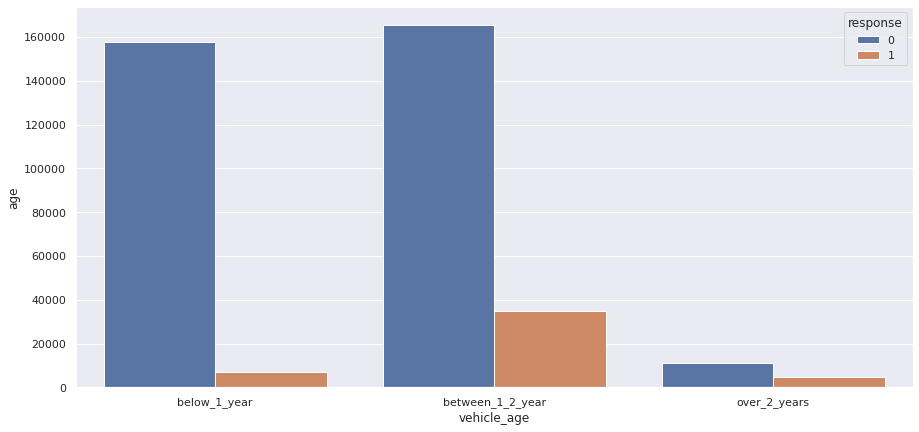

In [99]:
aux1 = df4[['response', 'vehicle_age', 'age']].groupby( ['vehicle_age', 'response'] ).count().reset_index()
sns.barplot( x='vehicle_age', y='age', hue='response', data=aux1 );

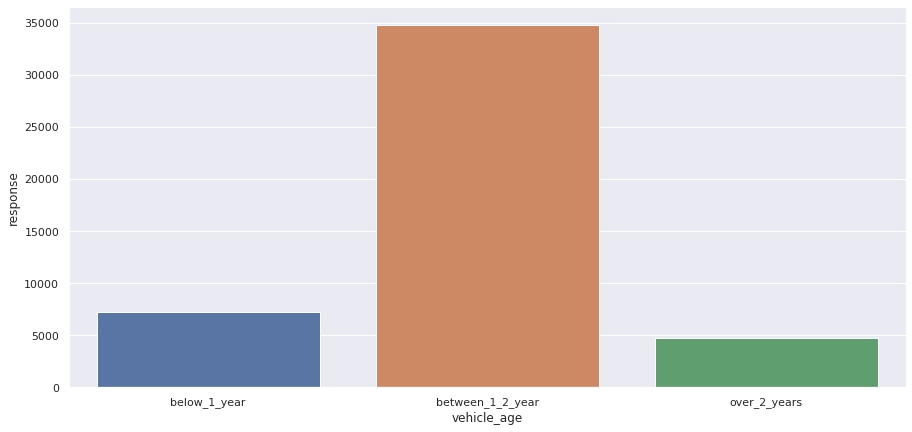

In [100]:
aux1 = df4[df4['response'] == 1]
aux2 = aux1[['response', 'vehicle_age']].groupby( 'vehicle_age' ).count().reset_index()
sns.barplot( x='vehicle_age', y='response', data=aux2 );

### **4.** Carros que nunca foram batidos possuem menos seguros de carro.

**VERDADEIRA** Clientes que nunca bateram o carro praticamente nunca compram um seguro de carro.

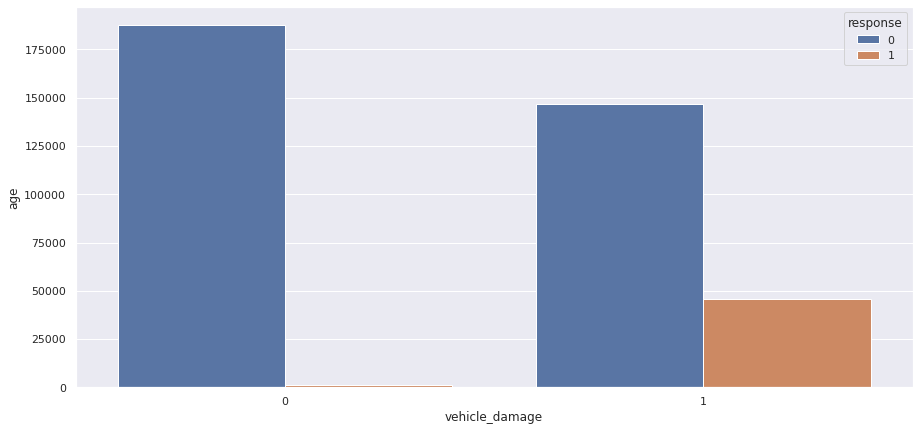

In [101]:
aux1 = df4[['response', 'vehicle_damage', 'age']].groupby( ['vehicle_damage', 'response'] ).count().reset_index()
sns.barplot( x='vehicle_damage', y='age', hue='response', data=aux1 );

### **5.** Clientes com planos de saúde mais caros, compram mais seguros de carro.

### **6.** Clientes que são segurados a mais tempo pelo plano de saúde, compram mais o seguro de carro.

In [68]:
df4.head()

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,7,0,23367.0,249,0,Male,23,11,152.0,1,below_1_year,1
1,13,1,31409.0,221,0,Female,41,15,14.0,1,between_1_2_year,0
2,18,1,46622.0,299,0,Female,25,35,152.0,1,below_1_year,0
3,31,0,2630.0,136,0,Female,26,8,160.0,1,below_1_year,0
4,39,0,42297.0,264,0,Male,45,8,124.0,1,between_1_2_year,1


# 5.0 STEP 05 - DATA PREPARATION

In [41]:
df5 = df4.copy()

In [42]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1 Standardization

In [43]:
ss = pp.StandardScaler()

# Annual Premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2 Rescaling 

In [44]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

## 5.3 Encoder

In [45]:
# region_code - target encoding / frequency encoding / weighted target encoding
target_encoding_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encoding_region_code )

In [46]:
# Gender - One Hot encoding / Target encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

In [47]:
# vehicle_age - one hot encoding / frequency encoding / order encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )


In [48]:
# policy_sales_channel - Target encoding / frequency encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

df5.groupby( 'response' ).size()

response
0    267565
1     37322
dtype: int64

## 5.4 Validation Preparation

In [49]:
# Gender - One Hot encoding / Target encoding
x_val.loc[:, 'gender'] = x_val['gender'].map( target_encode_gender )

# Annual Premium
x_val['annual_premium'] = ss.fit_transform( x_val[['annual_premium']].values )

# Age
x_val['age'] = mms_age.fit_transform( x_val[['age']].values )

# Vintage
x_val['vintage'] = mms_vintage.fit_transform( x_val[['vintage']].values )

# region_code - target encoding / frequency encoding / weighted target encoding
x_val.loc[:, 'region_code'] = x_val['region_code'].map( target_encoding_region_code )

# vehicle_age - one hot encoding / frequency encoding / order encoding
x_val = pd.get_dummies( x_val, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target encoding / frequency encoding
x_val.loc[:, 'policy_sales_channel'] = x_val['policy_sales_channel'].map( fe_policy_sales_channel )

# fillna
x_val = x_val.fillna( 0 )

# 6.0 STEP 06 - FEATURE SELECTION

In [50]:
# Model Definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# Data Preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                        feature  importance
0                       vintage    0.272884
0                annual_premium    0.244466
0                           age    0.165462
0                   region_code    0.105304
0                vehicle_damage    0.074014
0          policy_sales_channel    0.060575
0            previously_insured    0.048403
0      vehicle_age_below_1_year    0.014616
0  vehicle_age_between_1_2_year    0.006578
0                        gender    0.004913
0      vehicle_age_over_2_years    0.002311
0               driving_license    0.000475


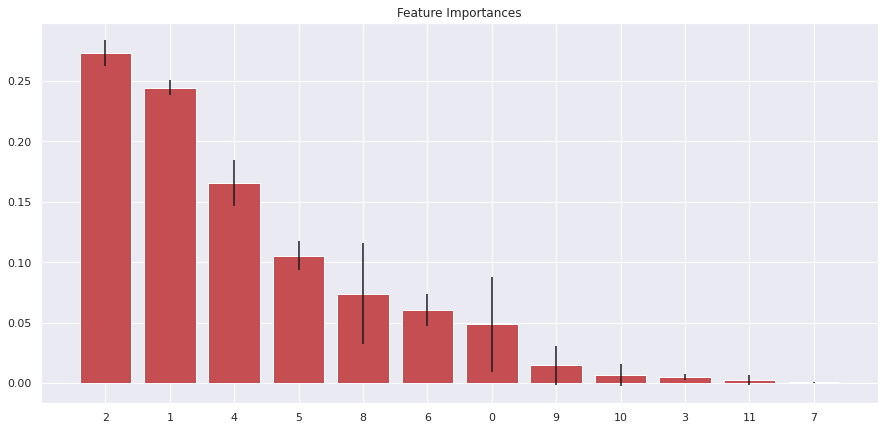

In [51]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# Print de Feature Ranking
print( 'Feature Ranking:' )
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( { 'feature': i, 'importance': j }, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title( 'Feature Importances' )
plt.bar( range( x_train_n.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range( x_train_n.shape[1] ), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

# 7.0 STEP 07 - MACHINE LEARNING MODELLING

In [52]:
cols_selected = [ 'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured' ]

x_train = df5[ cols_selected ]
x_val = x_val[ cols_selected ]

## 7.1 KNN

In [53]:
# Model Definition 
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# Model Training
knn_model.fit( x_train, y_train )

# Model Prediction 
yhat_knn = knn_model.predict_proba( x_val )

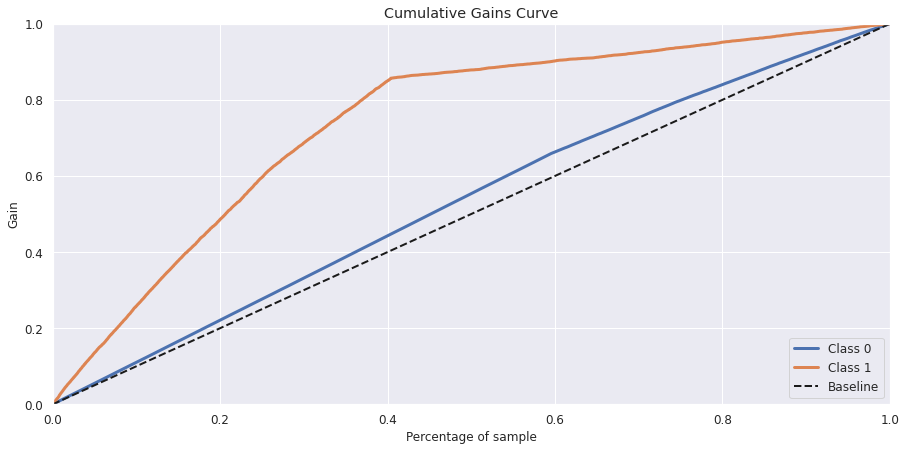

In [54]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

## 7.2 Logistic Regression

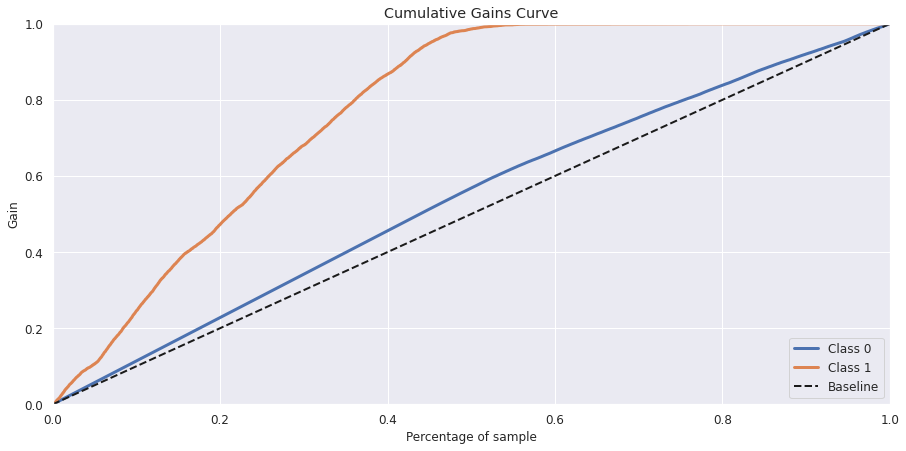

In [55]:
# Model Definition
lr_model = lm.LogisticRegression( random_state=42 )

# Model Training
lr_model.fit( x_train, y_train )

# Model Prediction
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );